In [1]:
from __future__ import print_function
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
pd.pandas.set_option('display.max_columns', None)
#pip install --upgrade gensim
import json
import operator
import collections
import re
import numpy as np
import pandas as pd
import nltk
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
train_dataset = json.load(open('train.json','r'))
test_dataset = json.load(open('test.json','r'))

In [3]:
ingredients = list()

for recipe in train_dataset:
    for ingredient in recipe[u'ingredients']:
        ingredients.append(ingredient.strip())

cuisines = list()
for recipe in train_dataset:
    cuisines.append(recipe[u'cuisine'].strip())
print("Total recipes in the train corpus",len(cuisines))

Total recipes in the train corpus 39774


# Dictionary of output labels

In [4]:
labels = set(cuisines)
labels = list(labels)
labels = { labels[i] : i for i in range(0, len(labels) ) }
print(labels)

{'french': 0, 'mexican': 1, 'korean': 2, 'spanish': 3, 'chinese': 4, 'indian': 5, 'cajun_creole': 6, 'filipino': 7, 'brazilian': 8, 'italian': 9, 'irish': 10, 'moroccan': 11, 'southern_us': 12, 'japanese': 13, 'russian': 14, 'jamaican': 15, 'greek': 16, 'thai': 17, 'british': 18, 'vietnamese': 19}


In [5]:
print('ingredients in the dataset: ',len((ingredients)))
print('unique ingredients in the dataset: ',len(set(ingredients)))

ingredients in the dataset:  428275
unique ingredients in the dataset:  6714


# Cleaning

In [6]:
import inflect
stemmer = inflect.engine()

recipes_as_sentences_list = list()

for recipe in train_dataset:
    clean_recipe = list()
    for ingredient in recipe['ingredients']:
        ingredient = re.sub(r'[^a-zA-Z\s]+', '', ingredient)
        ingredient =  re.sub(r'\(.*oz.\)|large|medium|small|extra|low-fat|warm|plain|hot|crushed|crumbles|ground|minced|chopped|sliced|heavy|grated|all-purpose|shredded|breakfast|whole|crumbled|self rising|low sodium|flat|diced|unsweetened','', ingredient)
        if stemmer.singular_noun(ingredient) is not False:
            ingredient = stemmer.singular_noun(ingredient)
        words_in_ingredients = nltk.tag.pos_tag(ingredient.split())
        words_in_ingredients=[word[0] for word in words_in_ingredients if word[1] in ('NN')]
        ingredient = " ".join(words_in_ingredients)
        ingredient = ingredient.strip().lower()
        clean_recipe.append(ingredient)
    while("" in clean_recipe) :
        clean_recipe.remove("")
    recipes_as_sentences_list.append(clean_recipe)

In [7]:
u_ingredients = set()
for recipe in recipes_as_sentences_list:
    for ingredient in recipe:
        u_ingredients.add(ingredient)
print('unique ingredients after cleaning the dataset: ',len(u_ingredients))

unique ingredients after cleaning the dataset:  3903


## TODO: Check why  and what '1719' ingredients were removed during cleaning.

In [8]:
ingredients_removed_in_cleaning = u_ingredients.difference(set(ingredients))
print(len(ingredients_removed_in_cleaning))

1719


# Generating context vectors of ingredients from the pre-trained word2vec model

In [9]:
num_features = 300              
min_word_count = 1                   
num_workers = 4
context = 10                                                                                

model = word2vec.Word2Vec(recipes_as_sentences_list, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

In [10]:
print("Before cleaning: ")
print(train_dataset[12342]["ingredients"])
print("After cleaning: ")
print(recipes_as_sentences_list[12342])
print("=======================================================")
print("Before cleaning: ")
print(train_dataset[122]["ingredients"])
print("After cleaning: ")
print(recipes_as_sentences_list[122])

Before cleaning: 
['light soy sauce', 'peeled shrimp', 'brown sugar', 'green onions', 'chicken stock', 'fresh ginger root', 'boneless pork loin', 'chinese rice wine', 'wonton wrappers']
After cleaning: 
['soy sauce', 'shrimp', 'brown sugar', 'onion', 'chicken stock', 'ginger root', 'boneless pork loin', 'rice wine', 'wonton wrapper']
Before cleaning: 
['tomato sauce', 'ground black pepper', 'garlic', 'scallions', 'chipotles in adobo', 'avocado', 'dried thyme', 'instant white rice', 'cilantro leaves', 'coconut milk', 'water', 'red beans', 'chopped celery', 'skinless chicken thighs', 'onions', 'lime zest', 'lime juice', 'lime wedges', 'salt', 'carrots']
After cleaning: 
['tomato sauce', 'pepper', 'garlic', 'scallion', 'chipotle adobo', 'avocado', 'thyme', 'rice', 'cilantro leaf', 'coconut milk', 'water', 'bean', 'celery', 'skinless chicken thigh', 'onion', 'lime zest', 'lime juice', 'lime wedge', 'salt', 'carrot']


In [11]:
model.similarity('ginger root', 'ginger')

0.9493743

In [12]:
print(model.wv.vectors.shape)
vocab = model.wv.vocab
#print(model['olive'])

(3903, 300)


In [13]:
ingredients_new = list()
for recipe in recipes_as_sentences_list:
    for ingredient in recipe:
        ingredients_new.append(ingredient.strip())
print(len((ingredients_new)))
ingredients_new_set = set(ingredients_new)
print(len((ingredients_new_set)))

#so there are no unknown 

416965
3903


In [14]:
unknown_ingredients = []
for ingredient in ingredients_new_set:
    if ingredient not in vocab.keys():
        unknown_ingredients.append(ingredient)

In [15]:
print(len(unknown_ingredients))

0


In [16]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    sent = [x for x in sent if x not in unknown_ingredients]
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
    return np.asarray(sent_vec) / numw

In [17]:
recipes_as_context_vectors_of_ingredients=[]
for sentence in recipes_as_sentences_list:
    recipes_as_context_vectors_of_ingredients.append(sent_vectorizer(sentence, model))

In [18]:
print("Length of vector", len(recipes_as_context_vectors_of_ingredients[0]))
print(recipes_as_sentences_list[0])
print("Context Vectors taindataset count records: ", len(recipes_as_context_vectors_of_ingredients))
print("Original taindataset count records: ",len(recipes_as_sentences_list))

Length of vector 300
['romaine lettuce', 'olive', 'grape tomato', 'garlic', 'pepper', 'onion', 'feta cheese']
Context Vectors taindataset count records:  39774
Original taindataset count records:  39774


# Update json tarindataset

In [19]:
for i,recipe in enumerate(train_dataset):
    recipe[u'ingredients'] = recipes_as_context_vectors_of_ingredients[i]
    recipe[u'cuisine'] = labels[recipe[u'cuisine']]

# Convert Json to Pandas dataframe: Only for understanding and taken output variable from this dataframe

In [20]:
from pandas.io.json import json_normalize
train_dataset_new = json_normalize(train_dataset)
train_dataset_new.drop(['id'],axis=1,inplace=True)
train_dataset_new.head()

,cuisine,ingredients
0,16,"[0.045165855, -0.18682246, -0.040208463, -0.14..."
1,12,"[-0.13681337, -0.068644695, -0.18498793, 0.160..."
2,7,"[-0.037796352, 0.18375583, -0.06670243, 0.0791..."
3,5,"[0.17552686, -0.026997099, -0.21593082, 0.2682..."
4,5,"[-0.043211795, -0.09228353, -0.20805445, 0.235..."


# Machine Learning

In [21]:
data = pd.DataFrame(recipes_as_context_vectors_of_ingredients)
print(data.shape)
data.head()

(39774, 300)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.045166,-0.186822,-0.040208,-0.148948,0.220548,-0.046828,-0.242472,0.109549,0.050461,-0.167338,-0.032712,0.033797,0.255913,0.217057,0.183838,0.186438,0.212896,-0.100058,-0.030988,-0.006509,-0.068120,-0.134243,0.187796,-0.322893,0.011005,0.460759,-0.013859,-0.057261,0.127298,0.007886,0.258933,-0.506016,0.296045,0.161354,0.099015,0.242064,-0.085300,0.366964,-0.127331,0.042244,0.008465,0.211612,-0.109408,-0.189282,0.298782,-0.043736,0.306647,0.022697,0.153046,0.174936,-0.159109,-0.143167,-0.086205,-0.189728,0.254133,-0.207078,0.255723,0.107128,0.149582,-0.286775,0.421800,0.169201,0.080213,-0.087006,0.367575,0.278083,0.018064,-0.100739,-0.029645,0.101898,0.334677,0.084815,0.085055,0.130905,-0.037206,-0.057518,-0.201832,0.383903,0.052853,-0.290861,-0.311752,0.147616,-0.069472,0.034865,0.039413,0.057296,-0.032883,0.178930,-0.041066,-0.291091,-0.282419,0.603306,-0.442489,-0.327670,-0.263256,0.461867,0.023616,0.439441,0.235254,0.373382,-0.190634,-0.221493,-0.667009,-0.082607,-0.006312,-0.390579,-0.134744,0.199869,-0.047040,-0.095199,0.438204,0.175492,-0.114987,-0.110947,-0.409854,-0.133315,-0.233369,0.179327,0.113631,0.124691,-0.231633,0.082733,-0.298423,0.326031,0.329030,0.157246,0.043023,-0.406806,-0.019210,0.097610,0.154527,-0.028668,0.007515,0.157075,0.274354,-0.145701,0.505673,-0.304795,-0.314147,0.487233,0.017175,-0.057374,-0.086568,-0.270234,-0.086852,0.188279,-0.033689,-0.337834,0.145169,0.113222,-0.062634,-0.435245,-0.306094,0.171984,-0.089011,-0.144320,0.123949,0.113529,-0.320610,-0.164778,-0.135140,-0.064684,-0.177959,0.108942,-0.544299,0.027349,0.356871,-0.118159,0.238216,0.115817,0.297036,0.648095,-0.648513,-0.161086,0.081983,0.004553,-0.661199,-0.273057,-0.232438,0.492083,-0.091234,0.121208,0.234660,-0.040876,0.214551,0.206691,-0.378760,0.091240,-0.276305,0.348394,0.189202,-0.039899,0.007252,0.023891,0.180608,-0.044694,-0.113823,0.068996,-0.500981,0.261934,0.043847,-0.401673,-0.230929,0.057447,0.205273,-0.200156,-0.412095,0.099247,-0.012548,-0.704206,-0.237615,-0.304809,0.399941,-0.150039,0.057990,-0.394538,0.487589,0.292059,-0.145009,-0.312687,0.369353,-0.254717,-0.082460,-0.041843,-0.054188,0.541652,-0.327549,-0.123172,0.026107,0.611200,0.024999,0.263751,-0.162226,0.190246,0.009556,-0.056675,-0.358250,0.259278,-0.118742,0.078036,-0.371248,0.163460,0.123380,0.073944,0.094856,-0.374406,0.075558,-0.270153,-0.604539,0.019539,-0.008587,0.439927,0.039825,0.188154,-0.379745,0.210087,-0.085910,0.056213,-0.022947,0.209829,-0.346199,0.232295,-0.160025,-0.139382,0.597834,0.286008,0.060557,-0.062150,0.075570,-0.494240,-0.026763,0.198833,0.116072,0.043847,-0.073603,-0.102847,-0.263390,0.052392,-0.461331,0.035556,0.104598,-0.242080,0.499110,-0.069143,-0.250825,-0.146353,-0.033547,0.205885,0.253693,-0.447286,-0.378392,0.163971,0.358968,-0.275628,-0.135233,-0.086473,-0.145747,0.550188,0.094567,-0.226367
1,-0.136813,-0.068645,-0.184988,0.160385,0.605337,0.204769,

In [24]:
label_data = train_dataset_new.cuisine
print(label_data.shape)
label_data.head()
final_data = pd.concat([data, label_data], axis=1)
print(final_data.shape)
final_data.head()

(39774,)
(39774, 301)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,cuisine
0,0.045166,-0.186822,-0.040208,-0.148948,0.220548,-0.046828,-0.242472,0.109549,0.050461,-0.167338,-0.032712,0.033797,0.255913,0.217057,0.183838,0.186438,0.212896,-0.100058,-0.030988,-0.006509,-0.068120,-0.134243,0.187796,-0.322893,0.011005,0.460759,-0.013859,-0.057261,0.127298,0.007886,0.258933,-0.506016,0.296045,0.161354,0.099015,0.242064,-0.085300,0.366964,-0.127331,0.042244,0.008465,0.211612,-0.109408,-0.189282,0.298782,-0.043736,0.306647,0.022697,0.153046,0.174936,-0.159109,-0.143167,-0.086205,-0.189728,0.254133,-0.207078,0.255723,0.107128,0.149582,-0.286775,0.421800,0.169201,0.080213,-0.087006,0.367575,0.278083,0.018064,-0.100739,-0.029645,0.101898,0.334677,0.084815,0.085055,0.130905,-0.037206,-0.057518,-0.201832,0.383903,0.052853,-0.290861,-0.311752,0.147616,-0.069472,0.034865,0.039413,0.057296,-0.032883,0.178930,-0.041066,-0.291091,-0.282419,0.603306,-0.442489,-0.327670,-0.263256,0.461867,0.023616,0.439441,0.235254,0.373382,-0.190634,-0.221493,-0.667009,-0.082607,-0.006312,-0.390579,-0.134744,0.199869,-0.047040,-0.095199,0.438204,0.175492,-0.114987,-0.110947,-0.409854,-0.133315,-0.233369,0.179327,0.113631,0.124691,-0.231633,0.082733,-0.298423,0.326031,0.329030,0.157246,0.043023,-0.406806,-0.019210,0.097610,0.154527,-0.028668,0.007515,0.157075,0.274354,-0.145701,0.505673,-0.304795,-0.314147,0.487233,0.017175,-0.057374,-0.086568,-0.270234,-0.086852,0.188279,-0.033689,-0.337834,0.145169,0.113222,-0.062634,-0.435245,-0.306094,0.171984,-0.089011,-0.144320,0.123949,0.113529,-0.320610,-0.164778,-0.135140,-0.064684,-0.177959,0.108942,-0.544299,0.027349,0.356871,-0.118159,0.238216,0.115817,0.297036,0.648095,-0.648513,-0.161086,0.081983,0.004553,-0.661199,-0.273057,-0.232438,0.492083,-0.091234,0.121208,0.234660,-0.040876,0.214551,0.206691,-0.378760,0.091240,-0.276305,0.348394,0.189202,-0.039899,0.007252,0.023891,0.180608,-0.044694,-0.113823,0.068996,-0.500981,0.261934,0.043847,-0.401673,-0.230929,0.057447,0.205273,-0.200156,-0.412095,0.099247,-0.012548,-0.704206,-0.237615,-0.304809,0.399941,-0.150039,0.057990,-0.394538,0.487589,0.292059,-0.145009,-0.312687,0.369353,-0.254717,-0.082460,-0.041843,-0.054188,0.541652,-0.327549,-0.123172,0.026107,0.611200,0.024999,0.263751,-0.162226,0.190246,0.009556,-0.056675,-0.358250,0.259278,-0.118742,0.078036,-0.371248,0.163460,0.123380,0.073944,0.094856,-0.374406,0.075558,-0.270153,-0.604539,0.019539,-0.008587,0.439927,0.039825,0.188154,-0.379745,0.210087,-0.085910,0.056213,-0.022947,0.209829,-0.346199,0.232295,-0.160025,-0.139382,0.597834,0.286008,0.060557,-0.062150,0.075570,-0.494240,-0.026763,0.198833,0.116072,0.043847,-0.073603,-0.102847,-0.263390,0.052392,-0.461331,0.035556,0.104598,-0.242080,0.499110,-0.069143,-0.250825,-0.146353,-0.033547,0.205885,0.253693,-0.447286,-0.378392,0.163971,0.358968,-0.275628,-0.135233,-0.086473,-0.145747,0.550188,0.094567,-0.226367,16
1,-0.136813,-0.068645,-0.184988,0.160385,0.60533

# VVIMP there are two NaN's in the dataset that we should remove and also keep this in mind while analysing the missclassification ... Why? to keep the dataset consistent during analysis

In [25]:
print("Indices of NaN: ", pd.isnull(data).any(1).nonzero()[0])
nan_data_indices = list(pd.isnull(data).any(1).nonzero()[0])
final_data= final_data.dropna()
print("Indices of NaN: ", pd.isnull(final_data).any(1).nonzero()[0])
output_label = final_data['cuisine']
final_label_data = final_data.cuisine
print(len(final_label_data))
final_data.drop(['cuisine'],axis=1,inplace=True)

Indices of NaN:  [13178 23512]
Indices of NaN:  []
39772


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_data, output_label, shuffle=False, stratify=None, test_size=0.15, random_state=42)

In [64]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
train_score = clf.score(X_train,y_train)
test_score = clf.score(X_test,y_test)
print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

train:  0.6495296692894752
test:  0.6436473348977539


# DON'T ecxecute below code it is for GLOVE

# Jump to cell 41 .. below is for Glove which dint work well

## TODO: current accuracy 55% check how to improve

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

print('Best score for training data:', svm_model.best_score_,"\n") 

embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

len(embeddings_dict)
iterator = iter(embeddings_dict.items())
for i in range(1):
    print(next(iterator))

def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    sent = [x for x in sent if x not in unknown_ingredients]
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
    return np.asarray(sent_vec) / numw

unknown_ingredients = []
for ingredient in ingredients_new_set:
    if ingredient not in embeddings_dict.keys():
        unknown_ingredients.append(ingredient)

print(len(unknown_ingredients))

recipes_as_context_vectors_of_ingredients=[]
for sentence in recipes_as_sentences_list:
    recipes_as_context_vectors_of_ingredients.append(sent_vectorizer(sentence, embeddings_dict))

print("Length of vector", len(recipes_as_context_vectors_of_ingredients[0]))
print(recipes_as_sentences_list[0])
print("Context Vectors taindataset count records: ", len(recipes_as_context_vectors_of_ingredients))
print("Original taindataset count records: ",len(recipes_as_sentences_list))

train_dataset = json.load(open('train.json','r'))
for i,recipe in enumerate(train_dataset):
    recipe[u'ingredients'] = recipes_as_context_vectors_of_ingredients[i]
    recipe[u'cuisine'] = labels[recipe[u'cuisine']]

from pandas.io.json import json_normalize
train_dataset_new = json_normalize(train_dataset)
train_dataset_new.drop(['id'],axis=1,inplace=True)
train_dataset_new.head()

data = pd.DataFrame(recipes_as_context_vectors_of_ingredients)
print(data.shape)
data.head()

label_data = train_dataset_new.cuisine
print(label_data.shape)
label_data.head()
final_data = pd.concat([data, label_data], axis=1)
print(final_data.shape)
final_data.head()

print("Indices of NaN: ", pd.isnull(data).any(1).nonzero()[0])
final_data= final_data.dropna()
print("Indices of NaN: ", pd.isnull(final_data).any(1).nonzero()[0])
output_label = final_data['cuisine']
final_data.drop(['cuisine'],axis=1,inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_data, output_label, test_size=0.15, random_state=42)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

# Analysis

In [28]:
predictions = clf.predict(X_train)
predictions_test = clf.predict(X_test)

# These are predictions by our LR model for train+test of train.json

### Note: We are not considering test.json as there are no actual output labels present in the dataset. Since we are doing Supervised Learning.... ie. Classification Problem.

In [36]:
print(len(predictions))
print(len(list(y_train)))

print(len(predictions_test))
print(len(list(y_test)))

33806
33806
5966
5966


In [40]:
print(predictions[:10])
print((list(y_train)[:10]))

[16 12 12  9  5 12  1 12  1  9]
[16, 12, 7, 5, 5, 15, 3, 9, 1, 9]


# Merge Both Train and Test Prediction for complete analysis

In [32]:
total_predictions = list(predictions) + list(predictions_test)
len(total_predictions)

39772

## Note we can see that there were two NaN entries in our context vector generated dataset thus we should remove those recipes from the original dataset to maintain the dataset consistent, ie [13178, 23512]

In [33]:
nan_data_indices

[13178, 23512]

# below cell for confusion matrix

from sklearn import metrics
cm = metrics.confusion_matrix(y_train, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(train_score)
plt.title(all_sample_title, size = 15);

# Identifying indices of those recipes which have been missclassifed by the model

In [41]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(list(final_label_data), total_predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

In [42]:
print(misclassifiedIndexes[:15])
print(len(misclassifiedIndexes))

[2, 3, 5, 6, 7, 16, 17, 19, 22, 26, 37, 38, 41, 45, 46]
13974


In [43]:
train_dataset = json.load(open('train.json','r'))
for i,recipe in enumerate(train_dataset):
    recipe[u'cuisine'] = labels[recipe[u'cuisine']]
train_dataset_new_for_analysing_missclassfication = json_normalize(train_dataset)	
train_dataset_new_for_analysing_missclassfication.drop(axis=0, index=nan_data_indices, inplace=True)               
train_dataset_new_for_analysing_missclassfication.drop(['id'],axis=1,inplace=True)
train_dataset_new_for_analysing_missclassfication.reset_index(drop=True, inplace=True)
print(train_dataset_new_for_analysing_missclassfication.shape)
train_dataset_new_for_analysing_missclassfication.head()

(39772, 2)


,cuisine,ingredients
0,16,"[romaine lettuce, black olives, grape tomatoes..."
1,12,"[plain flour, ground pepper, salt, tomatoes, g..."
2,7,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,5,"[water, vegetable oil, wheat, salt]"
4,5,"[black pepper, shallots, cornflour, cayenne pe..."


In [44]:
missclassifed_data = train_dataset_new_for_analysing_missclassfication.loc[ misclassifiedIndexes , : ]

In [45]:
missclassifed_data.head()

,cuisine,ingredients
2,7,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,5,"[water, vegetable oil, wheat, salt]"
5,15,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,3,"[olive oil, salt, medium shrimp, pepper, garli..."
7,9,"[sugar, pistachio nuts, white almond bark, flo..."


In [46]:
def get_key(val): 
    for key, value in labels.items(): 
         if val == value:
            return key
    return "key doesn't exist"

In [47]:
print(pd.isnull(missclassifed_data).any(1).nonzero()[0])
df1 = missclassifed_data[missclassifed_data.isna().any(axis=1)]

[]


In [48]:
for i, row in missclassifed_data.iterrows():
    missclassifed_data.at[i, 'cuisine_label'] = get_key(int(row["cuisine"]))
missclassifed_data.drop(['cuisine'],axis=1,inplace=True)
missclassifed_data.rename(columns={'cuisine_label':'cuisine'}, inplace=True)

In [49]:
print(len(missclassifed_data))
missclassifed_data.head()

13974


,ingredients,cuisine
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...",filipino
3,"[water, vegetable oil, wheat, salt]",indian
5,"[plain flour, sugar, butter, eggs, fresh ginge...",jamaican
6,"[olive oil, salt, medium shrimp, pepper, garli...",spanish
7,"[sugar, pistachio nuts, white almond bark, flo...",italian


In [50]:
#missclassifed_data.to_json(orient='records')
missclassifed_data.cuisine.unique()

array(['filipino', 'indian', 'jamaican', 'spanish', 'italian', 'british',
       'vietnamese', 'southern_us', 'cajun_creole', 'brazilian',
       'chinese', 'french', 'japanese', 'irish', 'thai', 'korean',
       'moroccan', 'greek', 'mexican', 'russian'], dtype=object)

In [51]:
misclassified_data_count = missclassifed_data.groupby('cuisine').count()
misclassified_data_count

,ingredients
cuisine,
brazilian,458
british,785
cajun_creole,665
chinese,468
filipino,553
french,1697
greek,696
indian,376
irish,580


In [52]:
train_dataset = json.load(open('train.json','r'))
print(train_dataset[0]["ingredients"])
print(recipes_as_sentences_list[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
['romaine lettuce', 'olive', 'grape tomato', 'garlic', 'pepper', 'onion', 'feta cheese']


In [53]:
#These are cleaned ingredients
train_dataset = json.load(open('train.json','r'))

for i,recipe in enumerate(train_dataset):
    recipe[u'ingredients'] = recipes_as_sentences_list[i]

In [54]:
train_dataset_pd = json_normalize(train_dataset)
train_dataset_pd.drop(axis=0, index=nan_data_indices, inplace=True)
train_dataset_pd.reset_index(drop=True, inplace=True)
train_dataset_pd.drop(['id'],axis=1,inplace=True)
train_dataset_pd_count = train_dataset_pd.groupby('cuisine').count()
train_dataset_pd_count

,ingredients
cuisine,
brazilian,467
british,804
cajun_creole,1546
chinese,2673
filipino,755
french,2645
greek,1175
indian,3003
irish,667


# Find the % of each cuisine wrt to the entire dataset

In [55]:
total_records = train_dataset_pd.shape[0]

In [56]:
original_cuisine_ratio = dict()
for k, v in train_dataset_pd_count["ingredients"].items():
     original_cuisine_ratio[k] = round(((v/total_records)*100), 2)

In [61]:
original_cuisine_ratio

{'brazilian': 1.17,
 'british': 2.02,
 'cajun_creole': 3.89,
 'chinese': 6.72,
 'filipino': 1.9,
 'french': 6.65,
 'greek': 2.95,
 'indian': 7.55,
 'irish': 1.68,
 'italian': 19.71,
 'jamaican': 1.32,
 'japanese': 3.58,
 'korean': 2.09,
 'mexican': 16.19,
 'moroccan': 2.06,
 'russian': 1.23,
 'southern_us': 10.86,
 'spanish': 2.49,
 'thai': 3.87,
 'vietnamese': 2.07}

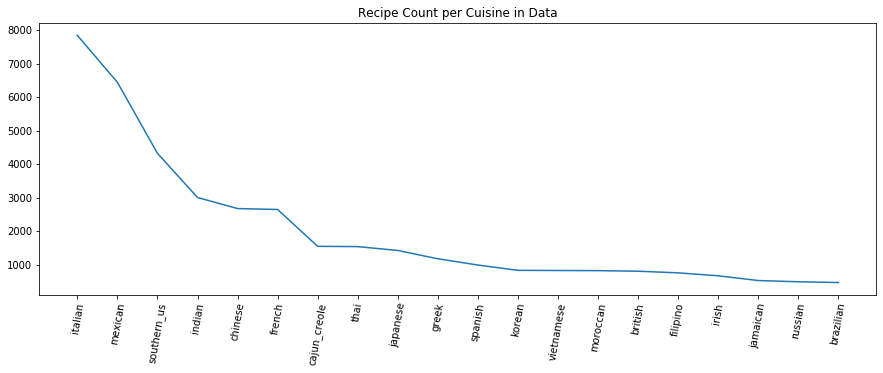

In [63]:
plt.figure(figsize=(15,5))
plt.title('Recipe Count per Cuisine in Data')
ax = train_dataset_pd.cuisine.value_counts().plot()
plt.xticks(np.arange(len(train_dataset_pd.cuisine.unique())), train_dataset_pd.cuisine.value_counts().index, rotation=80)
plt.show()

# Thus, in this case it makes lot of sense to only consider Italian and Mexican Cuisine for our missclassification analysis of ingredients as the dataset is unbalaned

# I mean the analysis of ingredients

# Missclassification % per cuisine

In [58]:
misclassified_data_count_dict = misclassified_data_count.to_dict()
train_dataset_pd_count = train_dataset_pd_count.to_dict()

In [59]:
missclassification_cuisine_ratio = dict()
for (k,v), (k2,v2) in zip(misclassified_data_count_dict["ingredients"].items(), train_dataset_pd_count["ingredients"].items()):
    missclassification_cuisine_ratio[k] = round(((v/v2)*100), 2)

In [60]:
missclassification_cuisine_ratio

{'brazilian': 98.07,
 'british': 97.64,
 'cajun_creole': 43.01,
 'chinese': 17.51,
 'filipino': 73.25,
 'french': 64.16,
 'greek': 59.23,
 'indian': 12.52,
 'irish': 86.96,
 'italian': 13.42,
 'jamaican': 70.72,
 'japanese': 51.72,
 'korean': 72.65,
 'mexican': 10.34,
 'moroccan': 57.25,
 'russian': 95.09,
 'southern_us': 30.49,
 'spanish': 96.87,
 'thai': 25.03,
 'vietnamese': 81.45}

# TODO: Analyse Italian and Mexican cuisines' ingredients and understand or research if the misclassified ingredients of Italian and Mexican cuisine have any relation with other cuisines.